# Run 1462 $\omega_a$ analysis 
### for the November 2017 $g-2$ analysis tutorial

In [1]:
import ROOT as r
import math

Welcome to JupyROOT 6.08/06


In [2]:
f = r.TFile('~/Downloads/gm2offline_run1462.root')
cluster_tree = f.Get('clusterAnalyzer/analyzer/clusterTree')
c = r.TCanvas()

define some constants, times are in $\mu$s

In [3]:
cyclotron = 0.149
gamma = 29.3
omega_a_ref =  2 * math.pi / (gamma * cyclotron);
t_start = 72
t_end = 200
bin_width = 0.149 * 4 
n_bins = (t_end - t_start)/bin_width

define string that will be used to generate 5-parameter fit functions of the form $N_0 \cdot \exp(-t/\tau) \cdot \left[1 + A_c \cos(\omega_a t) + A_s\sin(\omega_a t)\right]$.
$\omega_a$ will be parameterized as $\omega_{a,ref} (1 + \textrm{R})$, with R in ppm.

In [4]:
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6))+[3]*sin(x*[5]*(1+[4]*1e-6)))'

generate T-method histogram, with somewhat arbitrary energy cuts for now
assuming about 0.7 pe/MeV, the cut here looks at energies between about 1900 and 3100 MeV.

In [5]:
cluster_tree.Draw('(time*1.25/1000.0-{0})>>wiggle({1},0,{2})'.format(t_start,n_bins,t_end-t_start),
                  'energy>1400&&energy<2300','goff')
wiggle_hist = r.gROOT.FindObject('wiggle')

fit the wiggle plot

 FCN=214.738 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         576 TOTAL
                     EDM=9.38554e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            1.63452e+02   2.17858e+00   7.57621e-04   5.10967e-05
   2  #tau         6.58319e+01   1.03843e+00  -6.64292e-03   2.85444e-04
   3  A_{c}       -2.67096e-01   1.41393e-02   3.94780e-04  -1.48399e-02
   4  A_{s}        2.02667e-01   1.62424e-02  -2.90082e-04   3.88893e-03
   5  R           -1.74711e+03   7.24994e+02   7.24994e+02  -7.10823e-07
   6  p5           1.43922e+00     fixed    


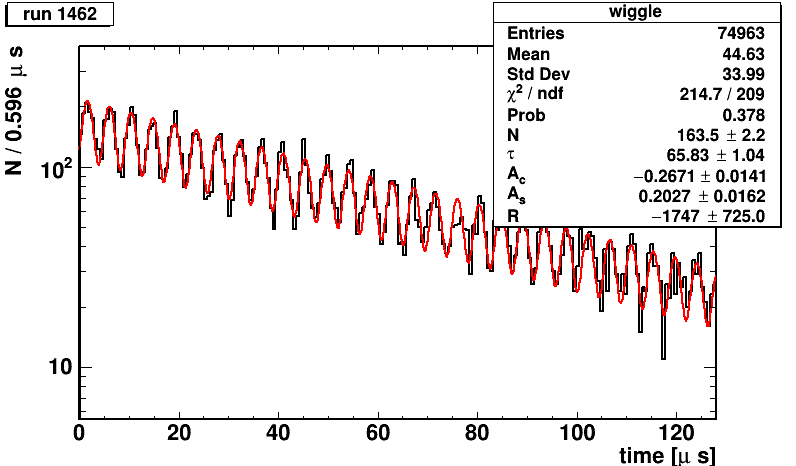

In [6]:
fit = r.TF1('fit',five_param_str,0, t_end-t_start)
r.gStyle.SetOptFit(1111)
fit.SetNpx(1000);
fit.SetParName(0, "N");
fit.SetParName(1, "#tau");
fit.SetParName(2, "A_{c}");
fit.SetParName(3, "A_{s}");
fit.SetParName(4, "R");
fit.SetLineColor(r.kRed);
fit.SetParameters(90.68, 66.38, -0.35, 0.19, 433, omega_a_ref);
fit.FixParameter(5, omega_a_ref);
wiggle_hist.Fit(fit, "EM");
wiggle_hist.SetTitle('run 1462; time [#mu s]; N / {} #mu s'.format(bin_width))
r.gPad.SetLogy(1);
c.Draw()

Interactive root plots are available with jsROOT, but it seems a little buggy sometimes

In [7]:
%jsroot on
wiggle_hist.Draw()
c.Draw()

In [8]:
%jsroot off

## Start Time Scans

create some book keeping variables

In [9]:
parameter_graphs = [r.TGraphErrors() for i in xrange(5)]
start_vals = [fit.GetParameter(i) for i in xrange(5)]
start_variances = [math.pow(fit.GetParError(i),2) for i in xrange(5)]
# graphs to keep track of -1 sigma bounds
low_bounds = [r.TGraph() for i in xrange(5)]
# graphs to keep track of +1 sigma bounds
high_bounds = [r.TGraph() for i in xrange(5)]
for i in xrange(5):
    parameter_graphs[i].SetTitle(";start time [#mus];{}".format(fit.GetParName(i)));
    low_bounds[i].SetLineStyle(2);
    high_bounds[i].SetLineStyle(2);

do the start time scan

In [10]:
for bin_index in xrange(1,101):
    this_start = wiggle_hist.GetBinLowEdge(bin_index)
    wiggle_hist.Fit(fit, 'EM' ,'', this_start, t_end - t_start)
    for par_index in xrange(5):
        parameter_graphs[par_index].SetPoint(bin_index-1, this_start, fit.GetParameter(par_index))
        parameter_graphs[par_index].SetPointError(bin_index-1, 0, fit.GetParError(par_index))
        par_variance = math.pow(fit.GetParError(par_index), 2)
        var_diff = par_variance - start_variances[par_index]
        var_drift = math.sqrt(var_diff) if var_diff > 0 else 0;
        high_bounds[par_index].SetPoint(bin_index - 1, this_start, start_vals[par_index ]+ var_drift)
        low_bounds[par_index].SetPoint(bin_index - 1, this_start, start_vals[par_index] - var_drift);

 FCN=214.738 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         473 TOTAL
                     EDM=1.54985e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            1.63452e+02   2.17857e+00   8.58461e-04   5.18041e-05
   2  #tau         6.58318e+01   1.03843e+00  -6.58457e-03   3.07608e-04
   3  A_{c}       -2.67098e-01   1.41392e-02   3.96367e-04  -1.50510e-02
   4  A_{s}        2.02673e-01   1.62422e-02  -2.96563e-04   3.11867e-03
   5  R           -1.74705e+03   7.24980e+02   7.24980e+02  -6.92200e-07
   6  p5           1.43922e+00     fixed    
 FCN=214.132 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         562 TOTAL
                     EDM=4.7256e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      D

display results

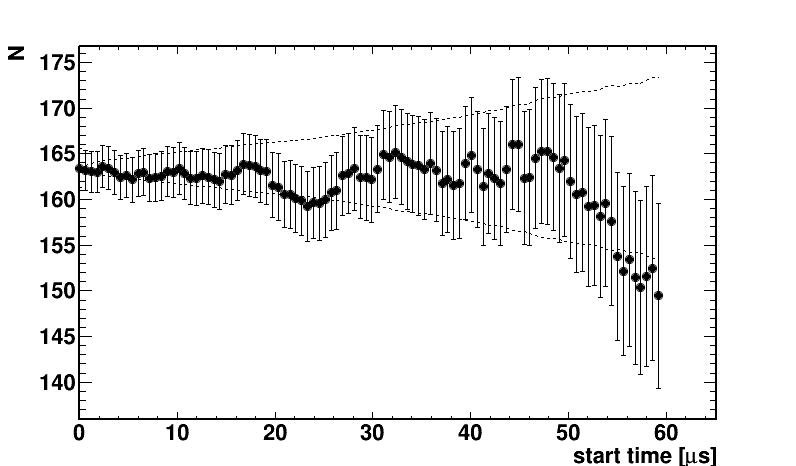

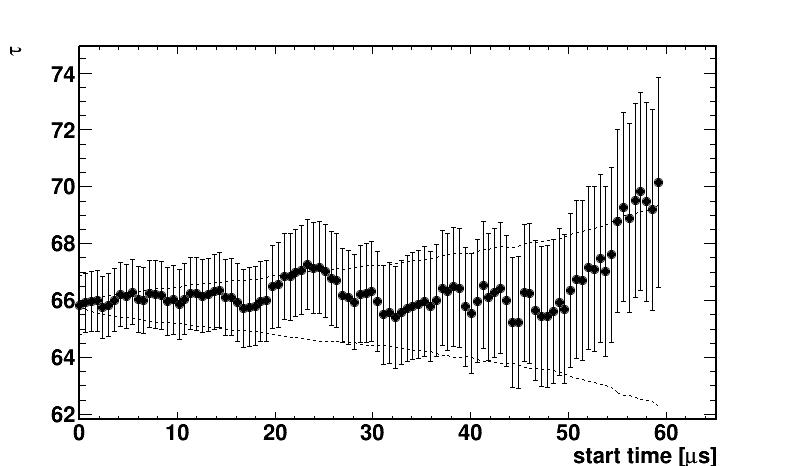

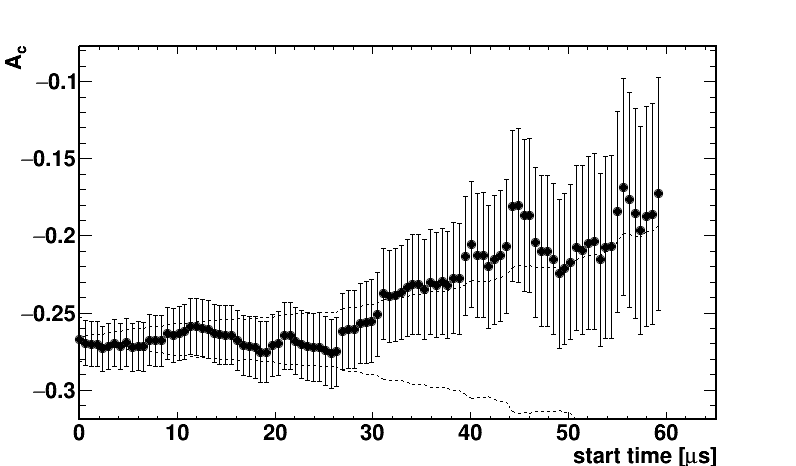

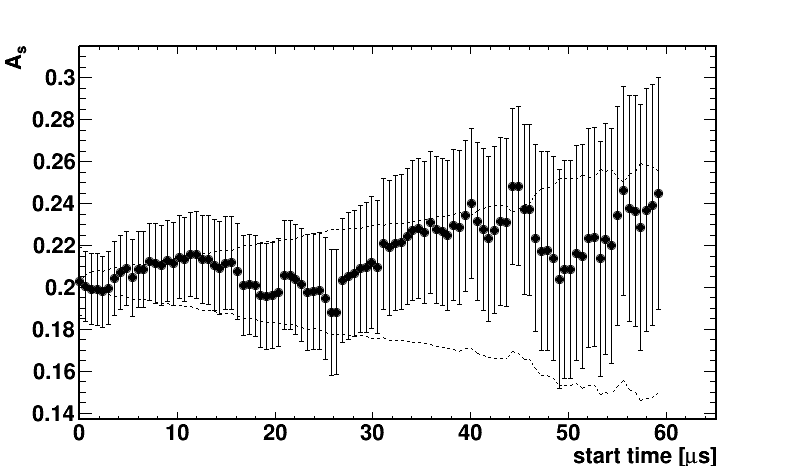

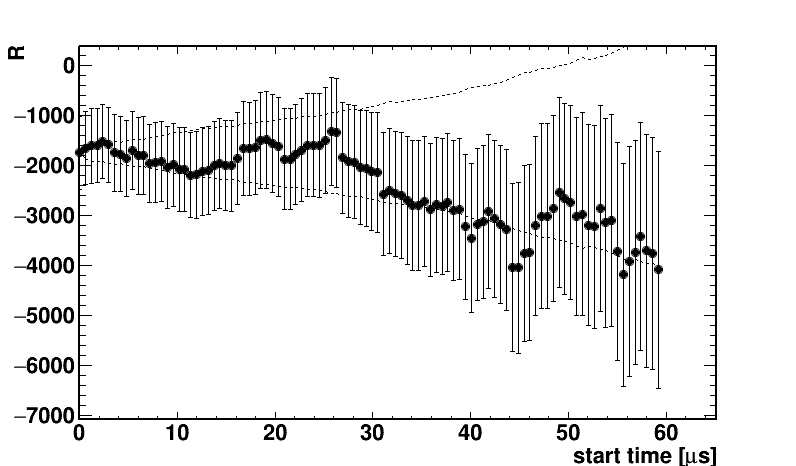

In [11]:
canvases = []
for i in xrange(5):
    canvases.append(r.TCanvas())
    parameter_graphs[i].Draw("ap")
    high_bounds[i].Draw("l same")
    low_bounds[i].Draw("l same")
    canvases[-1].Draw()

## Energy Threshold Sweep

build 2D N(t,E) spectrum to enable an easier threshold sweep

In [12]:
cluster_tree.Draw('energy:(time*1.25/1000.0-{0})>>wiggle2d({1},0,{2}, 200,300,2800)'.format(
    t_start, n_bins, t_end-t_start), '','goff')
wiggle_2d = r.gROOT.FindObject('wiggle2d')

create some TGraph and TGraphErrors objections to keep track of results

In [13]:
r_graph = r.TGraphErrors()
r_graph.SetTitle('run 1462;energy threshold [pe]; R')
precision_graph = r.TGraph()
precision_graph.SetTitle('run 1462;energy threshold [pe]; 1 / #sigma R')
A_graph = r.TGraphErrors()
A_graph.SetTitle('run 1462;energy threshold [pe]; A')
N_graph = r.TGraphErrors()
N_graph.SetTitle('run 1462;energy threshold [pe]; N')
NASquared_graph = r.TGraph()
NASquared_graph.SetTitle('run 1462;energy threshold [pe]; NA^{2}')

do the threshold sweep

In [14]:
wiggle_hist.Fit(fit, "EM");
yaxis = wiggle_2d.GetYaxis()
for i in xrange(1,131):
    e_thresh = yaxis.GetBinCenter(i)
    print(e_thresh)
    wiggle = wiggle_2d.ProjectionX('proj{}'.format(i), i, wiggle_2d.GetNbinsY())
    wiggle.Fit(fit, "EM")
    r_graph.SetPoint(i - 1, e_thresh, fit.GetParameter(4))
    precision_graph.SetPoint(i - 1, e_thresh, 1.0 / fit.GetParError(4))
    A_graph.SetPoint(i - 1, e_thresh, math.sqrt(math.pow(fit.GetParameter(2), 2) +
                                                math.pow(fit.GetParameter(3), 2)))
    N_graph.SetPoint(i - 1, e_thresh, wiggle.Integral());
    NASquared_graph.SetPoint(i - 1, e_thresh,
                       wiggle.Integral() * math.pow(fit.GetParameter(2), 2) +
                       math.pow(fit.GetParameter(3), 2));

 FCN=214.738 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         545 TOTAL
                     EDM=1.14385e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            1.63452e+02   2.17859e+00   4.81454e-04   5.14278e-05
   2  #tau         6.58320e+01   1.03844e+00  -6.71817e-03   3.38705e-04
   3  A_{c}       -2.67093e-01   1.41392e-02   3.91637e-04  -1.42349e-02
   4  A_{s}        2.02676e-01   1.62422e-02  -2.99439e-04   3.59911e-03
   5  R           -1.74707e+03   7.24984e+02   7.24984e+02  -7.22247e-07
   6  p5           1.43922e+00     fixed    
306.25
 FCN=203.145 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         521 TOTAL
                     EDM=6.75476e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZ

display results

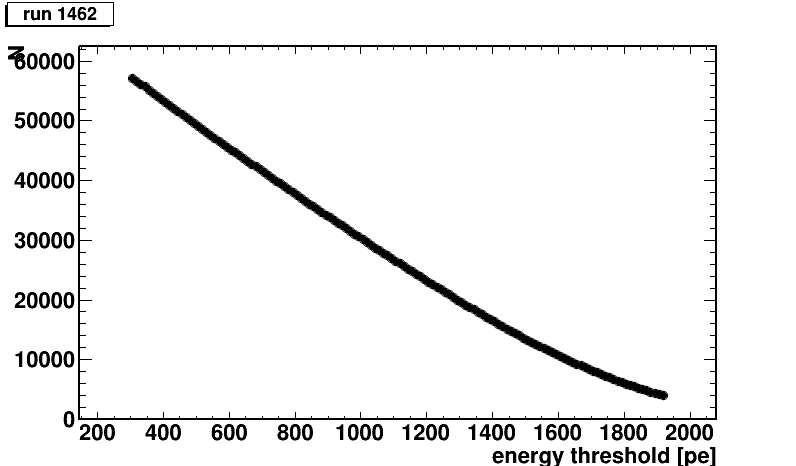

In [15]:
c = r.TCanvas()
N_graph.Draw('ap')
c.Draw()

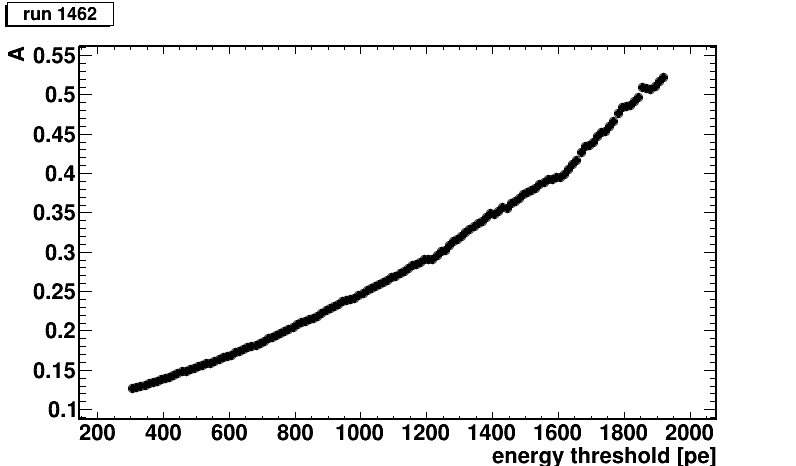

In [16]:
A_graph.Draw("ap")
c.Draw()

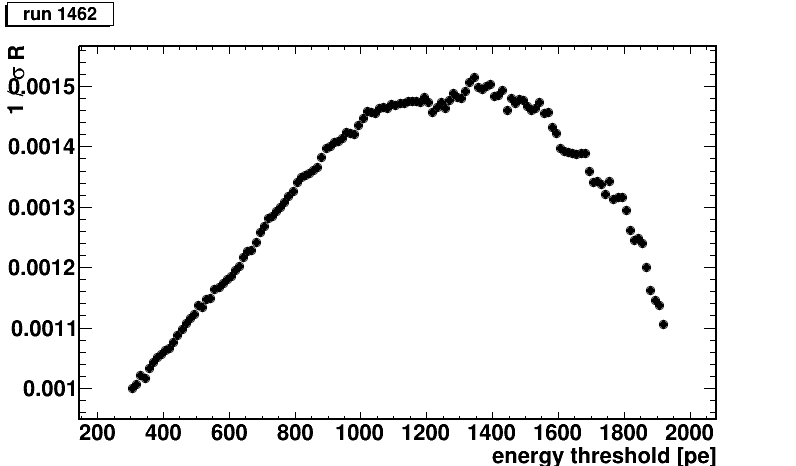

In [17]:
precision_graph.Draw('ap')
c.Draw()

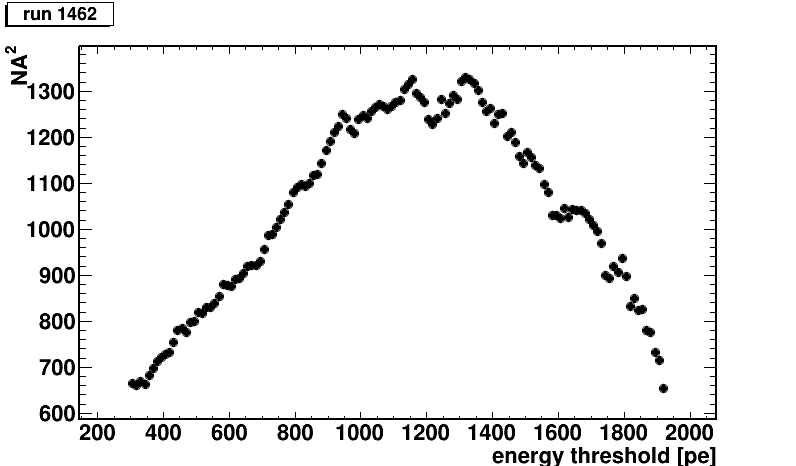

In [18]:
NASquared_graph.Draw('ap')
c.Draw()